In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
sns.set_theme()

In [32]:
# Carregar
data = pd.read_csv("../data/cleaned.csv", parse_dates=["data"])

# Criar features temporais
data['data'] = pd.to_datetime(data['data'])
data['dia_semana'] = data['data'].dt.dayofweek 
data['ds_sin'] = np.sin(2*np.pi*data['dia_semana']/7)
data['ds_cos'] = np.cos(2*np.pi*data['dia_semana']/7)
# data['mes'] = data['data'].dt.month
# data['mes_sin'] = np.sin(2*np.pi*(data['mes']-1)/12)
# data['mes_cos'] = np.cos(2*np.pi*(data['mes']-1)/12)

data['fim_de_semana'] = data['dia_semana'].isin([5,6]).astype(int)

# Definir target e features
y = data["pontuacao"]

num_cols = [
    "regularidade","duracao","sono_leve_perc","sono_profundo_perc","REM_perc",
    "tempo_acordado","vezes_acordado", "ds_sin","ds_cos","fim_de_semana"
]

X = data[num_cols]


In [33]:
X.head(7)

,regularidade,duracao,sono_leve_perc,sono_profundo_perc,REM_perc,tempo_acordado,vezes_acordado,ds_sin,ds_cos,fim_de_semana
0,90,478,70.50,8.16,21.34,6,3,0.433884,-0.900969,0
1,90,464,67.67,17.24,15.09,6,1,-0.433884,-0.900969,0
2,90,539,66.79,15.40,17.81,12,4,-0.974928,-0.222521,1
3,95,515,65.63,13.98,20.39,29,4,-0.781831,0.623490,1
4,89,428,60.28,16.82,22.90,15,2,0.000000,1.000000,0
5,88,420,64.05,15.71,20.24,8,2,0.781831,0.623490,0
6,88,408,59.07,20.59,20.34,16,2,0.974928,-0.222521,0


In [34]:
# Apenas numéricas, então aplicamos escalonamento (bom p/ regressões lineares)
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols)
])

In [35]:
# Pequeno dataset -> usar RepeatedKFold para mais estabilidade
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)


## Lasso

In [36]:
lasso_pipeline = Pipeline([
    ("preproc", preproc),
    ("model", Lasso(random_state=42))
])

param_dist = {
    "model__alpha": [0.01, 0.1, 1.0, 10],
    "model__max_iter": [500, 1000, 2000]
}

search_lasso = RandomizedSearchCV(
    lasso_pipeline, param_distributions=param_dist,
    n_iter=10, cv=cv, scoring="neg_mean_absolute_error",
    random_state=42, n_jobs=-1
)

search_lasso.fit(X, y)
best_lasso = search_lasso.best_estimator_
print("Melhores hiperparâmetros Lasso:", search_lasso.best_params_)
print("MAE (CV):", -search_lasso.best_score_)

Melhores hiperparâmetros Lasso: {'model__max_iter': 2000, 'model__alpha': 0.1}
MAE (CV): 3.280835307535674


In [37]:
# def optimize_model(model, param_dist, model_name, X, y):
#     """Função simplificada para otimização de modelos"""
#     pipeline = Pipeline([
#         ("preproc", preproc),
#         ("model", model)
#     ])
    
#     search = RandomizedSearchCV(
#         pipeline, param_distributions=param_dist,
#         n_iter=10, cv=cv, scoring="neg_mean_absolute_error",
#         random_state=42, n_jobs=-1
#     )
    
#     search.fit(X, y)
#     best_model = search.best_estimator_
#     best_mae = -search.best_score_
    
#     print(f"Melhores hiperparâmetros {model_name}: {search.best_params_}")
#     print(f"MAE (CV): {best_mae:.4f}\n")
    
#     return best_model, best_mae

In [38]:
# lasso_model, mae_lasso = optimize_model(
#     model=Lasso(random_state=42),
#     param_dist={"model__alpha": [0.01, 0.1, 1.0, 10], 
#                 "model__max_iter": [500, 1000, 2000]},
#     model_name="Lasso", 
#     X=X, 
#     y=y
# )

In [39]:

# linear_pipeline = Pipeline([
#     ("preproc", preproc),
#     ("model", LinearRegression())
# ])

# linear_pipeline.fit(X, y)
# # Esse já é o modelo final
# print(linear_pipeline.named_steps["model"])


## Ridge

In [40]:
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline([
    ("preproc", preproc),
    ("model", Ridge(random_state=42))
])

param_dist = {
    "model__alpha": [0.1, 1.0, 10.0, 50],
    "model__solver": ["auto", "svd", "cholesky", "lsqr"]
}

search_ridge = RandomizedSearchCV(
    ridge_pipeline, param_distributions=param_dist,
    n_iter=10, cv=cv, scoring="neg_mean_absolute_error",
    random_state=42, n_jobs=-1
)

search_ridge.fit(X, y)
best_ridge = search_ridge.best_estimator_
print("Melhores hiperparâmetros Ridge:", search_ridge.best_params_)
print("MAE (CV):", -search_ridge.best_score_)


Melhores hiperparâmetros Ridge: {'model__solver': 'lsqr', 'model__alpha': 10.0}
MAE (CV): 3.3174668926053927


In [41]:
# ridge_model, mae_ridge = optimize_model(
#     model=Ridge(random_state=42),
#     param_dist={
#         "model__alpha": [0.1, 1.0, 10.0, 50],
#         "model__solver": ["auto", "svd", "cholesky", "lsqr"]
#     },
#     model_name="Ridge", 
#     X=X, 
#     y=y
# )

## HGB

In [42]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_pipeline = Pipeline([
    ("preproc", preproc),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

param_dist = {
    "model__max_iter": [100, 300, 500],
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_leaf": [20, 50, 100],
    "model__learning_rate": [0.01, 0.1, 0.2]
}

search_hgb = RandomizedSearchCV(
    hgb_pipeline, param_distributions=param_dist,
    n_iter=20, cv=cv, scoring="neg_mean_absolute_error",
    random_state=42, n_jobs=-1
)

search_hgb.fit(X, y)
best_hgb = search_hgb.best_estimator_
print("Melhores hiperparâmetros HGB:", search_hgb.best_params_)
print("MAE (CV):", -search_hgb.best_score_)


Melhores hiperparâmetros HGB: {'model__min_samples_leaf': 20, 'model__max_iter': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
MAE (CV): 3.287400951170324


In [43]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preproc", preproc),
        ("model", model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="neg_mean_absolute_error")
    results[name] = -scores.mean()

pd.DataFrame.from_dict(results, orient="index", columns=["MAE"]).sort_values("MAE")


,MAE
HistGradientBoosting,3.287401
Ridge,3.325864
Lasso,3.332223
Linear,3.379519
RandomForest,3.689107


## RandomForest

In [44]:
rf_pipeline = Pipeline([
    ("preproc", preproc),
    ("model", RandomForestRegressor(random_state=42))
])

param_dist = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5]
}

search = RandomizedSearchCV(
    rf_pipeline, param_distributions=param_dist,
    n_iter=20, cv=cv, scoring="neg_mean_absolute_error",
    random_state=42, n_jobs=-1
)

search.fit(X, y)
print("Melhores hiperparâmetros:", search.best_params_)
print("MAE (CV):", -search.best_score_)
best_model = search.best_estimator_


Melhores hiperparâmetros: {'model__n_estimators': 500, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
MAE (CV): 3.418738857142856


In [50]:
# Para Linear Regression - avaliação completa no test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
)

# Treinar e avaliar Linear Regression
linear_pipeline.fit(X_train, y_train)
y_pred_linear = linear_pipeline.predict(X_test)

# Calcular todas as métricas
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Imprimir resultados
print("=== LINEAR REGRESSION - TEST SET ===")
print(f"MAE: {mae_linear:.4f}")
print(f"MSE: {mse_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")
print(f"R²: {r2_linear:.4f}")



=== LINEAR REGRESSION - TEST SET ===
MAE: 3.9719
MSE: 23.7696
RMSE: 4.8754
R²: 0.6576


MAE: 4.795866666666667
MSE: 31.133720800000003
RMSE: 5.579759923150816
R²: 0.5515309103713187


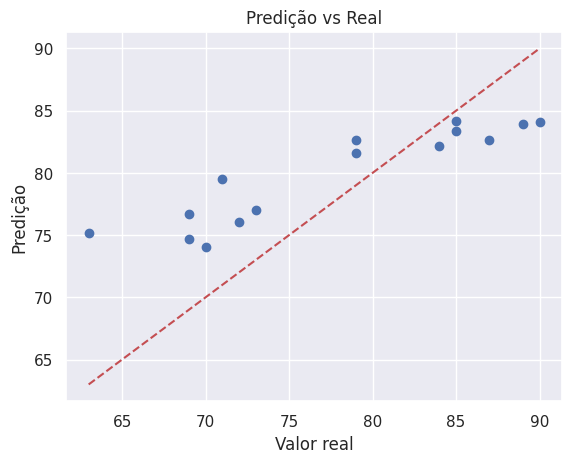

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score1 = r2_score(y_test, y_pred) 

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2_score1}")

plt.scatter(y_test, y_pred)
plt.xlabel("Valor real")
plt.ylabel("Predição")
plt.title("Predição vs Real")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()


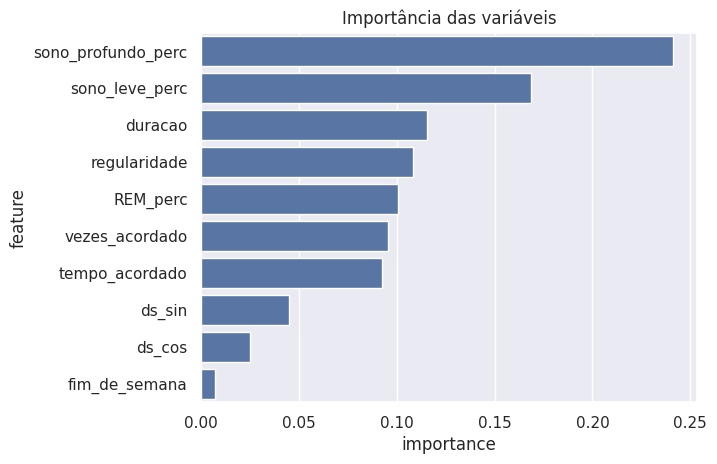

In [46]:
if hasattr(best_model.named_steps["model"], "feature_importances_"):
    importances = best_model.named_steps["model"].feature_importances_
    feat_imp = pd.DataFrame({
        "feature": num_cols,
        "importance": importances
    }).sort_values("importance", ascending=False)
    sns.barplot(data=feat_imp, x="importance", y="feature")
    plt.title("Importância das variáveis")
    plt.show()
